In [1]:
import os
import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv
load_dotenv(override=True)

TABLE_NAME = "users_churn"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "churn_nikolaistepanov_myown"
RUN_NAME = "eda"
ASSETS_DIR = "assets"

import os

os.makedirs(ASSETS_DIR, exist_ok=True)


pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,None,None,None,None,None,None,Female,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,None,None,None,None,None,None,Female,0,Yes,Yes,Yes,0


/tmp/ipykernel_5737/3053734827.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)
/tmp/ipykernel_5737/3053734827.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45)
/tmp/ipykernel_5737/3053734827.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45)


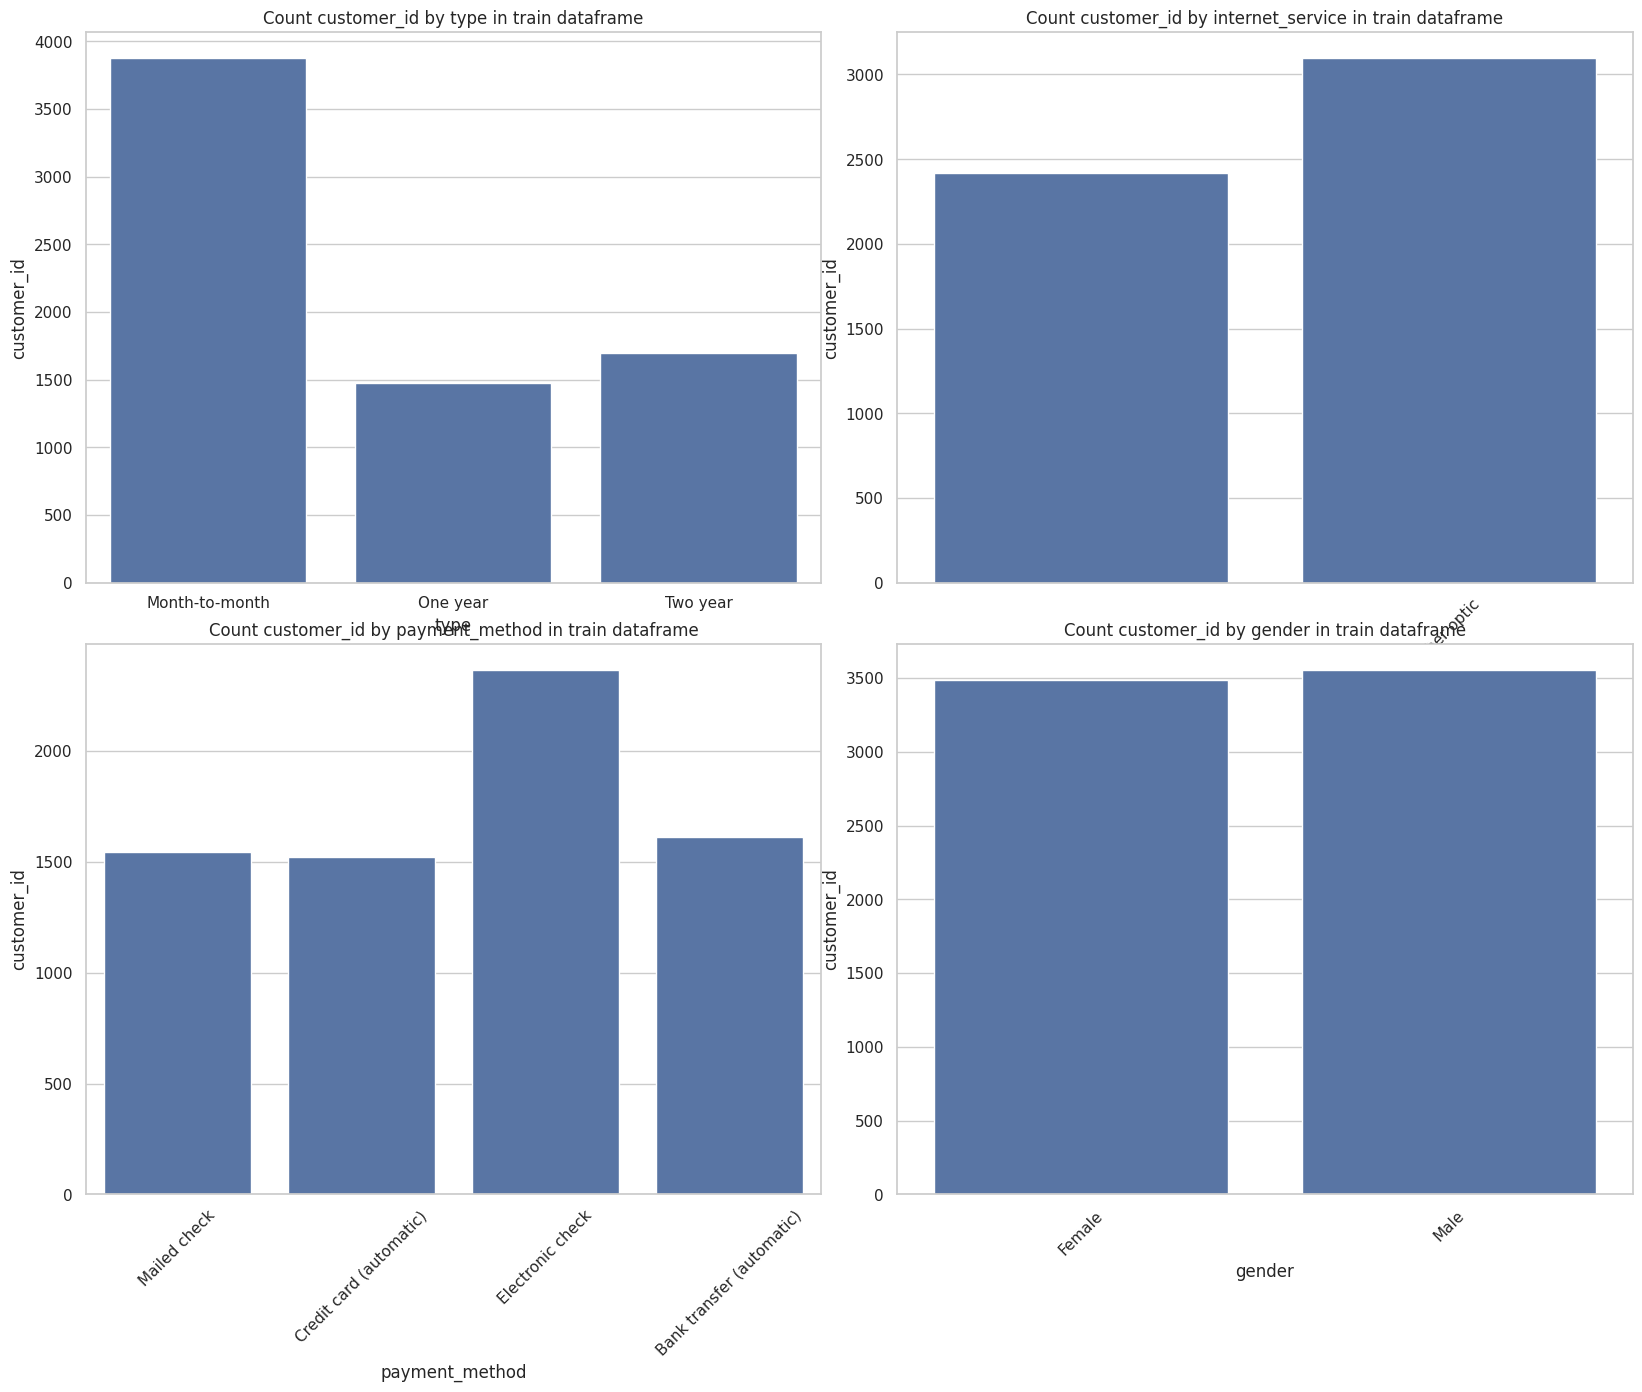

In [3]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({y: "count"})).reset_index() # ваш код тут #
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')


x = "payment_method"
y = "customer_id"
agg_df = pd.DataFrame(df.groupby(x).agg({y: "count"})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)


x = "internet_service"
y = "customer_id"
agg_df = pd.DataFrame(df.groupby(x).agg({y: "count"})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45)


x = "gender"
y = "customer_id"
agg_df = pd.DataFrame(df.groupby(x).agg({y: "count"})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45)

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_1"))
plt.show()

In [4]:
x = "customer_id"

binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]



print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv   
0                No            No                No           No           No  \
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

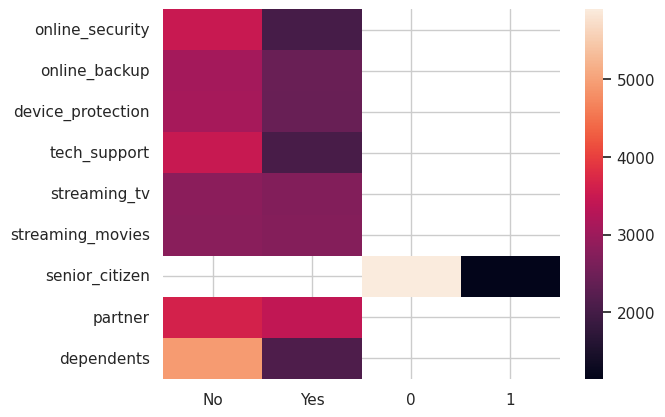

In [5]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T

sns.heatmap(data=heat_df)

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_2_binary_heatmap"))
plt.show()


In [6]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
heat_df

,No,Yes,0,1
online_security,3498.0,2019.0,NaN,NaN
online_backup,3088.0,2429.0,NaN,NaN
device_protection,3095.0,2422.0,NaN,NaN
tech_support,3473.0,2044.0,NaN,NaN
streaming_tv,2810.0,2707.0,NaN,NaN
streaming_movies,2785.0,2732.0,NaN,NaN
senior_citizen,NaN,NaN,5901.0,1142.0
partner,3641.0,3402.0,NaN,NaN
dependents,4933.0,2110.0,NaN,NaN


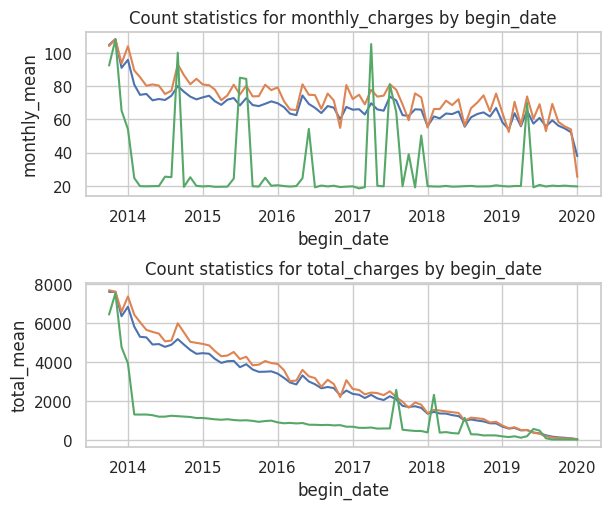

In [7]:
x = "begin_date"

charges_columns = ["monthly_charges", "total_charges"]

df.dropna(subset=charges_columns, how='any', inplace=True)

stats = ["mean", "median", lambda x: x.mode().iloc[0]]

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1) # ваш код здесь #
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# # сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, "charges_by_date"))



In [8]:
charges_monthly_agg

,begin_date,monthly_mean,monthly_median,monthly_mode
0,2013-10-01,104.800000,104.150,92.45
1,2013-11-01,108.325000,108.325,108.05
2,2013-12-01,91.066667,93.700,65.30
3,2014-01-01,95.864286,104.050,54.20
4,2014-02-01,80.934153,89.475,24.75
...,...,...,...,...
71,2019-09-01,59.490928,69.350,20.20
72,2019-10-01,56.259705,58.500,19.95
73,2019-11-01,54.602110,55.800,20.20
74,2019-12-01,52.312955,54.050,19.90


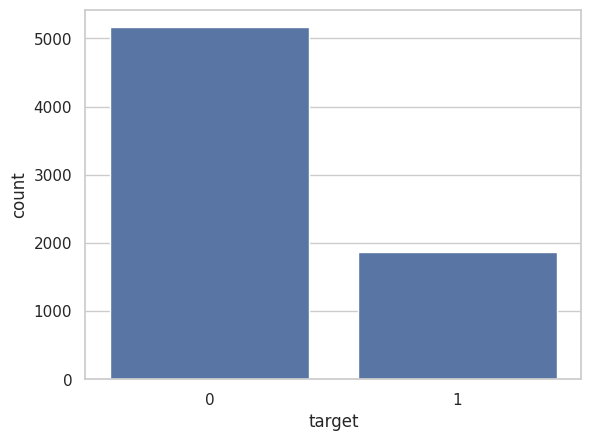

In [9]:
ASSETS_DIR = "assets"

x = "target"

target_agg = df[x].value_counts().reset_index()

sns.barplot(data=target_agg, x="target", y="count")

plt.savefig(os.path.join(ASSETS_DIR, "target_count"))

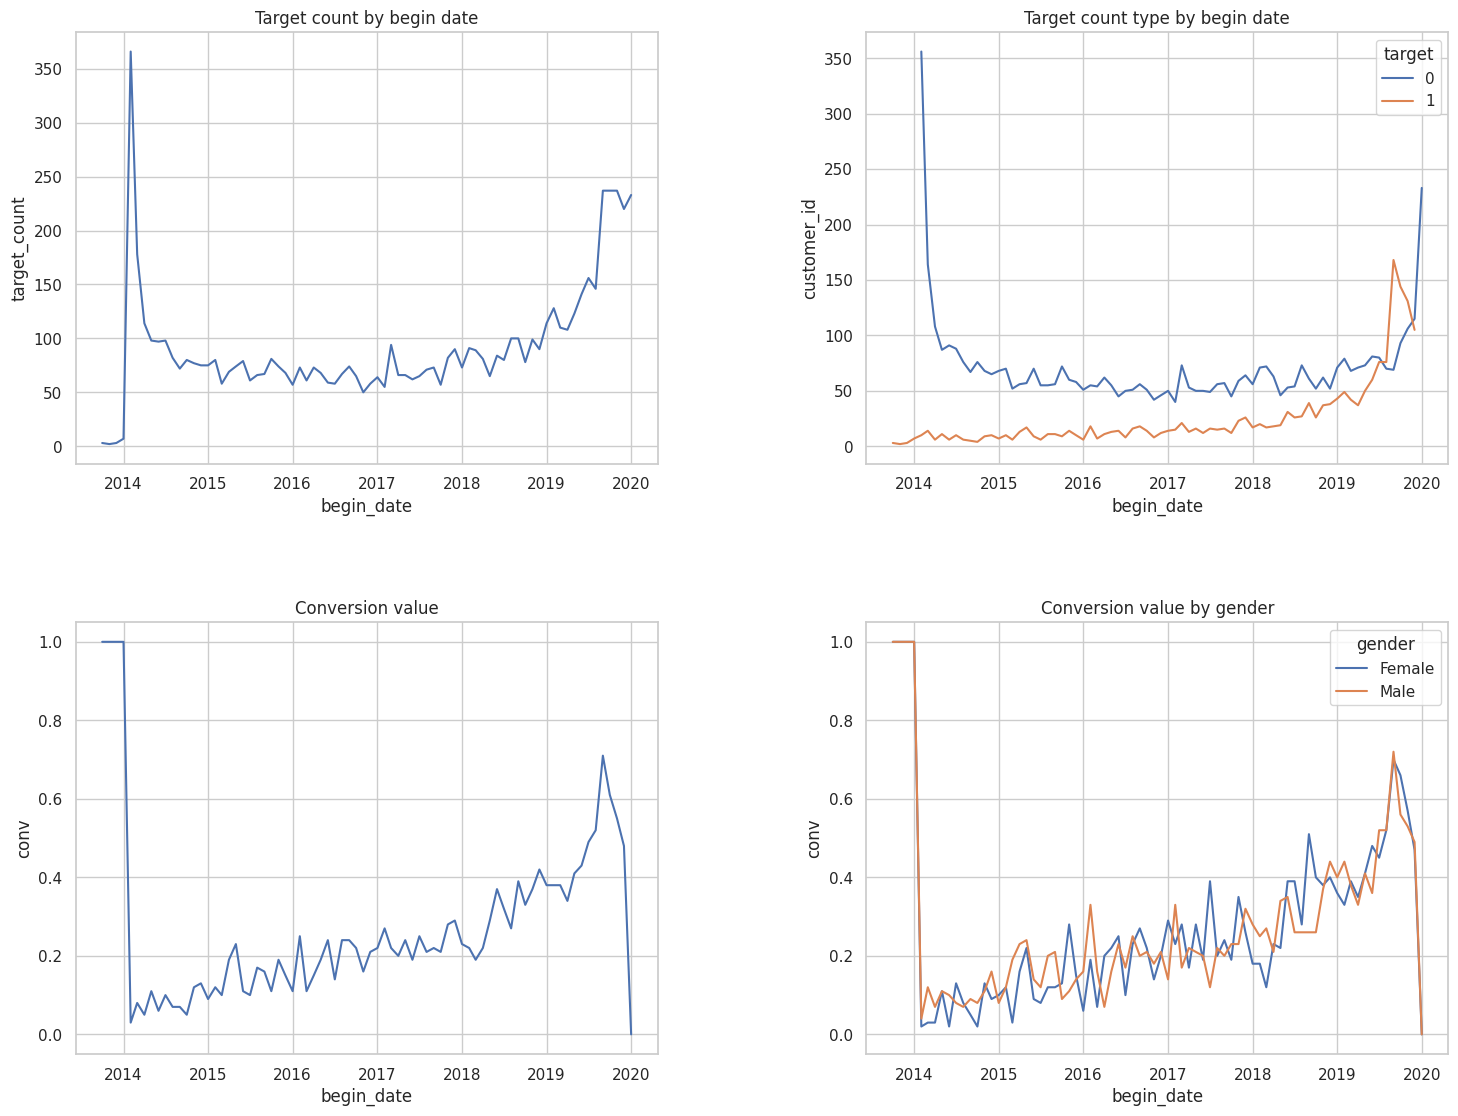

In [10]:
x = "begin_date"
target = "target"

stat = ["count"]

target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

target_agg = df[[x, target, "customer_id"]].groupby([x, target]).count().reset_index()

conversion_agg = df[[x, target]].groupby([x])["target"].agg(["sum", "count"]).reset_index()
conversion_agg["conv"] = (conversion_agg["sum"] / conversion_agg["count"]).round(2)

conversion_agg_gender = df[[x, target, "gender"]].groupby([x, "gender"])[target].agg(["sum", "count"]).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"] / conversion_agg_gender["count"]).round(2)

fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)

sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue="gender", ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

plt.savefig(os.path.join(ASSETS_DIR, "target_by_date"))

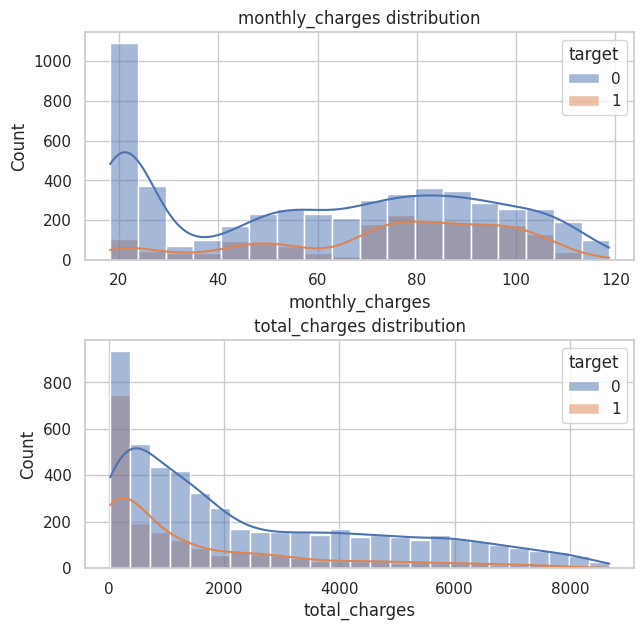

In [11]:
charges = ["monthly_charges", "total_charges"]
target = "target"

fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)
fig.set_size_inches(6.5, 6.5, forward=True)

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, "chargest_by_target_dist"))

In [12]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)

In [14]:
run_id

'46f2bbb449b94ad8be1e6f122e4b2374'